## Import & Setup

Note, if you are getting errors like this:
```
...
from .extension import *
  File ".../isaacsim/extsUser/go4robo/go4robo_python/extension.py", line 3, in <module>
    import omni.ext
ModuleNotFoundError: No module named 'omni'
```

Go into `isaacsim/extsUser/go4robo/go4robo_python/__init__.py` and comment out the following line:
```
from .extension import *
```

!! You need to uncomment this line if you plan to run the Isaac Sim extension !!

In [181]:
#Enable reloading because restarting the kernel is a pain
%load_ext autoreload
%autoreload 2

%pip install -q usd-core
%pip install -q pymoo

import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

import numpy as np

from isaacsim.extsUser.go4robo.go4robo_python.bot_3d_problem import *
from isaacsim.extsUser.go4robo.go4robo_python.bot_3d_rep import *

import json

import os, sys

import copy

import plotly.graph_objects as go
import seaborn as sns
import pandas as pd

from tqdm.notebook import trange, tqdm

sns.set_style("whitegrid")
sns.set_palette("husl")
sns.set_context("notebook", font_scale=1.5)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [182]:
run_id = "20250502_193211"

## Get the generated designs from csv

In [183]:
df_csv_path = f"/home/rachael/Documents/GitHub/go4robo/isaacsim/extsUser/go4robo/go4robo_python/results/designs_Robot_{run_id}.csv" # This should also contain the prior design at index 0

df = pd.read_csv(df_csv_path)
df

,id,Name,Cost,Perception Entropy,Generation,s0_type,s0_x,s0_y,s0_z,s0_qw,s0_qx,s0_qy,s0_qz
0,0,Prior Design,1.0,17.102970,0,1,0.000000,0.000000,0.250000,0.500000,-0.500000,-0.500000,-0.500000
1,1,Design 1,1.0,17.102970,1,1,0.878117,0.027388,0.670468,-0.160797,-0.514922,-0.193890,0.819394
2,2,Design 2,inf,inf,1,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,3,Design 3,1.0,17.102970,1,1,0.834626,0.018288,0.750144,-0.527595,0.683063,0.501794,0.057202
4,4,Design 4,1.0,3.483930,2,1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
477,477,Design 477,1.0,2.697809,49,1,0.210548,0.003231,0.000113,-0.471795,-0.092573,0.003949,0.876826
478,478,Design 478,1.0,2.697820,49,1,0.210548,0.003229,0.000214,-0.471795,-0.092604,0.004048,0.876822
479,479,Design 479,1.0,2.697824,49,1,0.210548,0.003231,0.000213,-0.473130,-0.092498,0.003946,0.876115
480,480,Design 480,1.0,2.697861,49,1,0.210395,0.003378,0.000113,-0.477717,-0.093735,0.003995,0.873489


## Plot the tradespace

Conveniently you can do this without the Problem definition, assuming you used the standard problem definition.

In [184]:
g4r_problem.plot_tradespace(df)

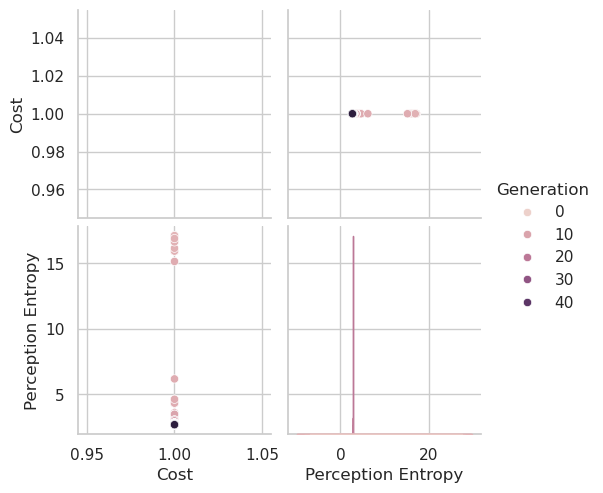

In [185]:
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1)

pair_plot_df = df[["Generation", "Cost", "Perception Entropy"]]
sns.pairplot(pair_plot_df, hue="Generation", diag_kind="kde")


## Set up the problem from json

In [186]:
json_prolem_path = f"/home/rachael/Documents/GitHub/go4robo/isaacsim/extsUser/go4robo/go4robo_python/results/problem_Robot_{run_id}.json" # This will contain the prior design at problem.prior_bot

problem_json_dict = json.load(open(json_prolem_path, 'r'))

problem = SensorPkgOptimization.from_json(problem_json_dict)

prior_bot_from_problem = problem.prior_bot

## Plot any bot from the df above

In [187]:
from plotly.subplots import make_subplots

INDEX_TO_PLOT = 481

design_x_dict = df[df["id"] == INDEX_TO_PLOT].iloc[0].to_dict()
bot_x = problem.convert_1D_to_bot(design_x_dict)
design_x_fig = bot_x.plot_bot_3d(
    perception_space=problem.perception_space,
    show=False,
    width=600,
)

design_0_dict = df[df["id"] == 0].iloc[0].to_dict()
bot_0 = problem.convert_1D_to_bot(design_0_dict)
design_0_fig = bot_0.plot_bot_3d(
    perception_space=problem.perception_space,
    show=False,
    width=600,
)

combined_fig = make_subplots(rows=1, cols=2, specs=[[{"type": "scene"}, {"type": "scene"}]])
for trace in design_0_fig.data:
    combined_fig.add_trace(trace, row=1, col=1)
for trace in design_x_fig.data:
    combined_fig.add_trace(trace, row=1, col=2)

combined_fig.update_layout(
    title_text=f"Design {INDEX_TO_PLOT} vs Design 0",
    showlegend=False,
    width=1200,
    height=600,
)

combined_fig.show()